<a href="https://colab.research.google.com/github/mikepratt1/emotion_detection/blob/notebook_experiments/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Detection Exploration Notebook
## In this notebook I intend to:
- Build a model for emotion detection based on the FER2013 [dataset](https://www.kaggle.com/datasets/msambare/fer2013?datasetId=786787&sortBy=voteCount&searchQuery=pytorch)
- I will use tensorboard to create experiments to optimise the model accuracy
- Following this notebook, I am going to deploy the model and use openCV

In [ ]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split
try:
  import torchinfo
except:
  print('Downloading torchinfo')
  !pip install torchinfo
  import torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load in the data from Kaggle
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michaelpratt","key":"317921af3552eab9b83039d5ecb842d7"}'}

In [ ]:
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## Step 1: Import data and visualise samples

In [ ]:
# First of all initialise the weights and the model so that we can extract the 
# necessary transforms
weights = torchvision.models.V#EfficientNet_B1_Weights.DEFAULT
model = torchvision.models.efficientnet_b1(weights=weights).to(device)
transform = weights.transforms()
transform

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Create torch dataset objects for both the train and test set using ImageFolder 
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((240,240)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])])

test_dataset = torchvision.datasets.ImageFolder(root="/content/test",
                                                transform=transform)
train_dataset = torchvision.datasets.ImageFolder(root="/content/train",
                                                 transform=transform)



Text(0.5, 1.0, 'Train')

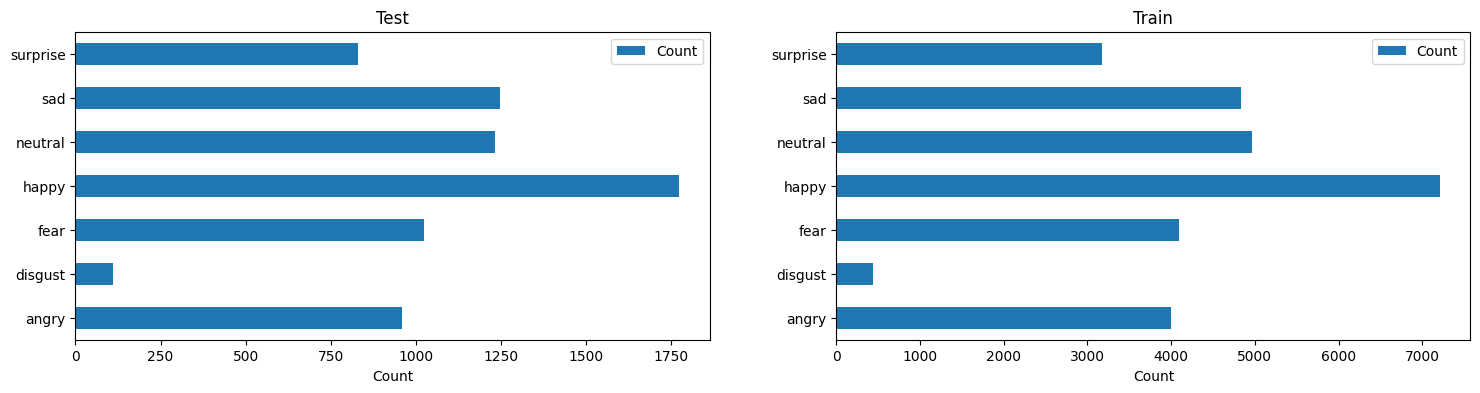

In [ ]:
# Examine the dataset ratios
from collections import Counter
import pandas as pd 

train_distribution = dict(Counter(train_dataset.targets))
test_distribution = dict(Counter(test_dataset.targets))

train_df = pd.DataFrame({"Count": [value for value in train_distribution.values()]}, index=[label_map[key] for key in train_distribution.keys()])
test_df = pd.DataFrame({"Count": [value for value in test_distribution.values()]}, index=[label_map[key] for key in test_distribution.keys()])

fig, ax = plt.subplots(1,2, figsize=(18,4))
test_df.plot(kind='barh', ax=ax[0])
train_df.plot(kind='barh', ax=ax[1])
ax[0].set_xlabel('Count')
ax[1].set_xlabel('Count')
ax[0].set_title('Test')
ax[1].set_title('Train')


- We can see there is a varying distribution of emotions
- Disgust is especially low, meaning any potential model will be poor at identifying disgust
- We need to do some work to even the count ratios for the training set

In [ ]:
class_weight = torch.Tensor([len(train_dataset) / c for c in pd.Series(train_distribution).sort_index()])
class_weight

tensor([ 7.1862, 65.8463,  7.0073,  3.9791,  5.7823,  5.9439,  9.0536])

In [ ]:
sample_weight = [0]*len(train_dataset)
for idx, (img, label) in enumerate(train_dataset):
  weight = class_weight[label]
  sample_weight[idx] = weight

sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weight, num_samples=len(train_dataset), replacement=True)

In [ ]:
# Create the dataloaders
BATCH_SIZE = 32

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=BATCH_SIZE,
                                              sampler=sampler)

In [ ]:
# Look at the size of our images
img, label = next(iter(train_dataloader))
img.shape, label.shape 


(torch.Size([32, 1, 240, 240]), torch.Size([32]))

- We can see a batch size of 32, images have 3 channels with 240 x 240 pixels
- There are 32 labels for 32 images

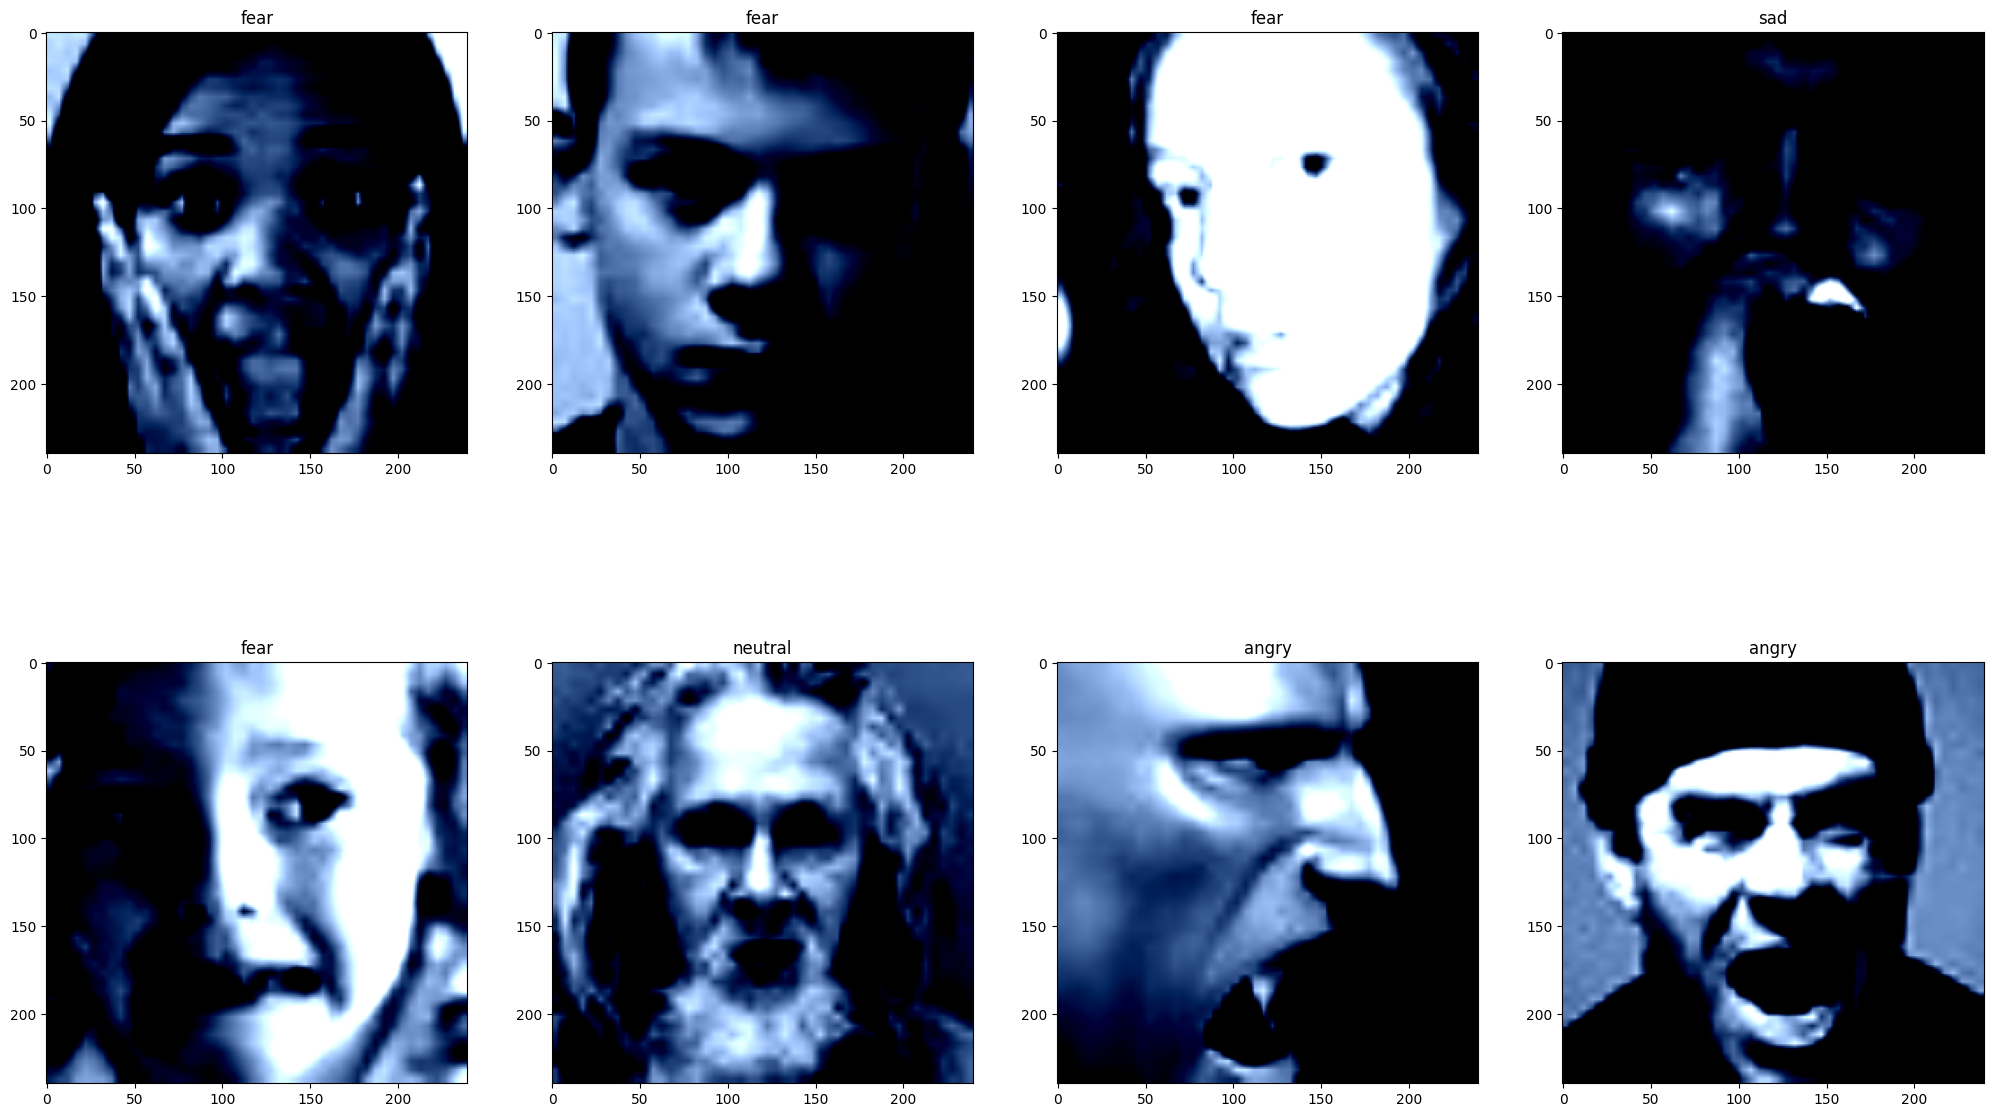

In [ ]:
# Let's visualise a couple of random images

label_map = {idx:label for idx, label in enumerate(train_dataset.classes)}

fig, ax = plt.subplots(2,4,figsize=(25,15))
for i in range(8):
  idx = torch.randint(0, len(train_dataset), size=[1])
  img, label = train_dataset[idx]
  ax[i//4, i%4].imshow(img.permute(1,2,0))
  ax[i//4, i%4].set_title(label_map[label])

plt.show()



## Step 2: Modify ResNet50 to be suitable for our dataset

In [ ]:
# Let's first of all visualise what the ResNet50 architecture looks like

torchinfo.summary(model=model,
                  input_size=(32,3,240,240),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 240, 240]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

In [ ]:
# Let's freeze layers all layers but the Linear layer
for param in model.parameters():
  param.requires_grad = False

# Adjust the output shape to accomodate for 5 classes
model.classifier[1] = nn.Sequential(
    nn.Linear(
        in_features=1280,
        out_features=len(train_dataset.classes)
    )
)
# model.fc = nn.Linear(
#         in_features=2048,
#         out_features=len(train_dataset.classes)
#     )

#Now what does it look like
torchinfo.summary(model=model,
                  input_size=(32,3,240,240),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 240, 240]    [32, 7]              --                   Partial
├─Sequential (features)                                      [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 

## Step 3: Training and testing loop

In [ ]:
# Define the loss function and the optimizer
from torch.optim.lr_scheduler import StepLR
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [ ]:
# Define the three functions above
from tqdm.auto import tqdm


# Set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 1. Training step function

def training_step(model, 
                  dataloader, 
                  loss_fn, 
                  optimizer,
                  device):

  # Put the model into training model
  model.train()

  # Loss and accuracy variables
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    # Move X and y to the device
    X, y = X.to(device), y.to(device)

    # forward pass
    y_logits = model(X)

    # Calculate the loss and the accuracy
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()
    scheduler.step()

    # predict the class
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    acc = (y_pred == y).sum().item()/len(y_pred)
    train_acc += acc

    if batch % 100 == 0:
      print(f"Batch {batch}: Train Accuracy: {acc} | Train Loss: {loss}")

  # Average the loss and accuracy over all batches
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


def test_step(model, 
                  dataloader, 
                  loss_fn, 
                  optimizer,
                  device):
  # Put the model in evaluation mode
  model.eval()

  # Test loss and accuracy variables
  test_loss, test_acc = 0, 0

  # Test the model
  with torch.inference_mode():
    for batch , (X, y) in enumerate(dataloader):
      # Move X and y to the device (gpu)
      X, y = X.to(device), y.to(device)

      # Forward pass to determine the logits
      test_pred_logits = model(X)

      # Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Convert logits to a classification prediction
      test_pred = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      
      # Calculate the accuracy
      acc = (test_pred == y).sum().item()/len(y)
      test_acc += acc
    
    # Average loss and accuracy over all batches
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


def train(model, 
          train_dataloader, 
          test_dataloader, 
          loss_fn, 
          optimizer, 
          epochs,
          device):
  results = {
      'train_loss': [],
      'test_loss': [],
      'train_acc': [],
      'test_acc': []
  }
  for epoch in range(epochs):
    print("-"*50, f"Epoch {epoch+1}", "-"*50)
    train_loss, train_acc = training_step(model,
                                          train_dataloader,
                                          loss_fn,
                                          optimizer,
                                          device)
    test_loss, test_acc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    optimizer,
                                    device)
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

    print(f"Train loss: {train_loss} | Train Accuracy: {train_acc} | Test Loss: "
          f"{test_loss} | Test Accuracy: {test_acc}")
  return results


In [ ]:
epochs = 10
results = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device)

-------------------------------------------------- Epoch 1 --------------------------------------------------


RuntimeError: ignored